# Analyzing earthquake data

<img src="https://risk-engineering.org/static/img/logo-RE.png" width="100" alt="" style="float:right;margin:15px;">

This notebook is an element of the [risk-engineering.org courseware](https://risk-engineering.org/). It can be distributed under the terms of the [Creative Commons Attribution-ShareAlike licence](https://creativecommons.org/licenses/by-sa/4.0/).

Author: Eric Marsden <eric.marsden@risk-engineering.org>. 

---

This notebook contains an introduction to the use of Python and SciPy to analyze data concerning earthquakes. See the [associated course materials](https://risk-engineering.org/statistical-modelling/) for background information and to download this content as a Jupyter notebook.

In [1]:
import numpy
import scipy.stats
import pandas
import matplotlib.pyplot as plt
plt.style.use("bmh")

The USGS provides data on earthquakes that occurred throughout the world at https://earthquake.usgs.gov/earthquakes/search/. For convenience, we have extracted data for 2017 earthquakes of magnitude larger than 5 in CSV format.

In [2]:
data = pandas.read_csv("https://risk-engineering.org/static/data/earthquakes-2017.csv")
data.head()

time  latitude  longitude   depth  mag magType  nst  \
0  2017-12-31T20:59:02.500Z  -53.0266  -118.3468   10.00  5.1      mb  NaN   
1  2017-12-31T20:27:49.390Z   -8.1161    68.0644   10.00  5.1     mww  NaN   
2  2017-12-31T14:53:31.580Z    5.4949   124.9006   30.80  5.1     mww  NaN   
3  2017-12-31T14:51:58.200Z  -11.8634   165.4973    9.55  5.1      mb  NaN   
4  2017-12-31T03:48:57.420Z   29.6759   129.3045  162.80  5.0     mww  NaN   

    gap    dmin   rms  ...                   updated  \
0  37.0  30.620  0.85  ...  2018-03-17T01:54:41.040Z   
1  59.0  12.965  0.72  ...  2018-03-17T01:54:41.040Z   
2  60.0   1.703  1.01  ...  2018-03-17T01:54:40.040Z   
3  74.0   5.963  1.03  ...  2018-03-17T01:54:40.040Z   
4  89.0   2.972  0.77  ...  2018-03-17T01:54:40.040Z   

                                place        type horizontalError depthError  \
0          Southern East Pacific Rise  earthquake            13.7        1.8   
1           Chagos Archipelago region  earthquake             6.5        1.8   
2       40km S of Daliao, Philippines  earthquake             6.7        4.0   
3  132km SSW of Lata, Solomon Islands  earthquake             9.1        4.1   
4              146km N of Naze, Japan  earthquake             7.6        4.2   

   magError  magNst    status  locationSource magSource  
0     0.053   117.0  reviewed              us        us  
1     0.062    25.0  reviewed              us        us  
2     0.073    18.0  reviewed              us        us  
3     0.059    92.0  reviewed              us        us  
4     0.065    23.0  reviewed              us        us  

[5 rows x 22 columns]

In [3]:
len(data)

1559

Let's clean up the data a little.

In [4]:
data.time = pandas.to_datetime(data.time)
data.sort_values("time", inplace=True)

Plot the data to see whether we can identify any visible patterns. 

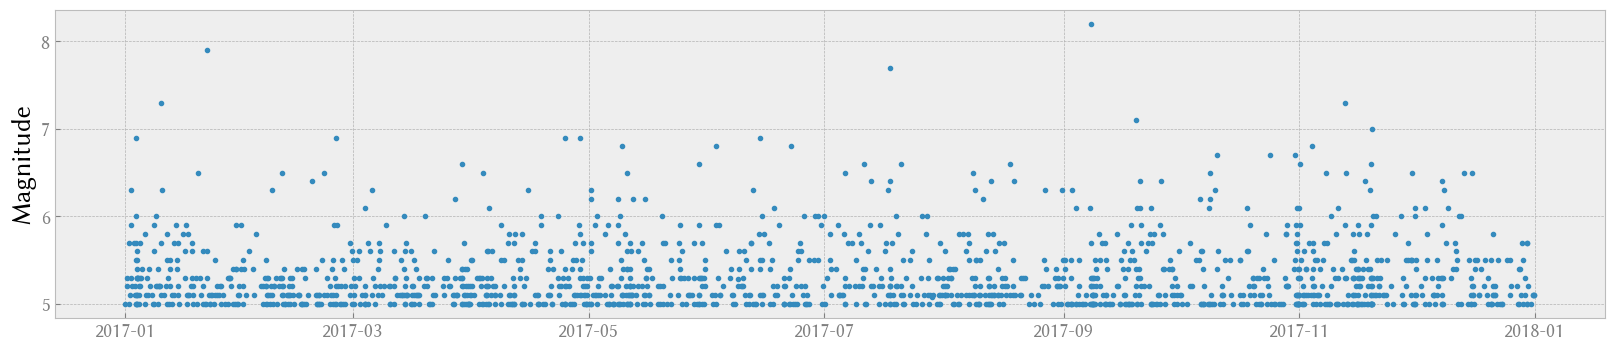

In [5]:
fig = plt.figure()
fig.set_size_inches(20, 4)
plt.plot(data.time, data.mag, ".");
plt.ylabel("Magnitude");

There's no visible trend in this time series. 

Let's examine the distribution of earthquake magnitudes (recall that we only have data for earthquakes of magnitude larger than 5). 

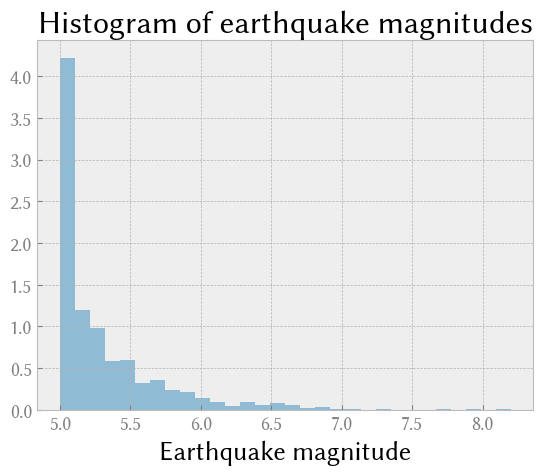

In [6]:
data.mag.hist(density=True, alpha=0.5, bins=30)
plt.xlabel("Earthquake magnitude")
plt.title("Histogram of earthquake magnitudes");

Earthquake arrivals follow a Poisson process. This means that interarrival times follow an exponential distribution.

In [7]:
duration = data.time.max() - data.time.min()
density = len(data) / float(duration.days)
density  # events per day

4.282967032967033

We can attempt to fit an exponential distribution to the interarrival times. 

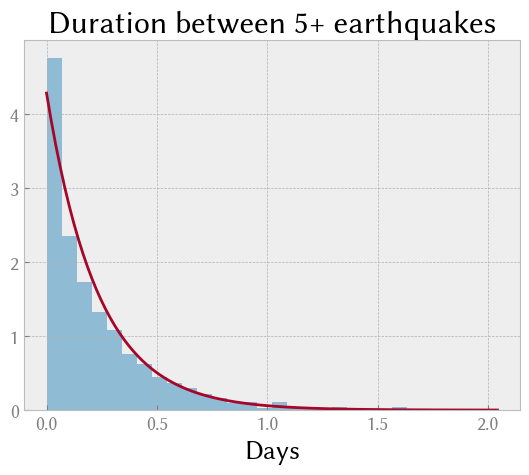

In [8]:
# calculate the time delta between successive rows and convert into days
interarrival = data.time.diff().dropna().apply(lambda x: x / numpy.timedelta64(1, "D"))
support = numpy.linspace(interarrival.min(), interarrival.max(), 100)
interarrival.hist(density=True, alpha=0.5, bins=30)
plt.plot(support, scipy.stats.expon(scale=1/density).pdf(support), lw=2)
plt.title("Duration between 5+ earthquakes")
plt.xlabel("Days");

It looks like the inter-event times do indeed fit an exponential distribution well. To check, generate a probability plot against the exponential distribution. This shows quantiles from our sample against quantiles from the theoretical distribution. If the points are close to the diagonal red line, the sample closely follows the distribution. 

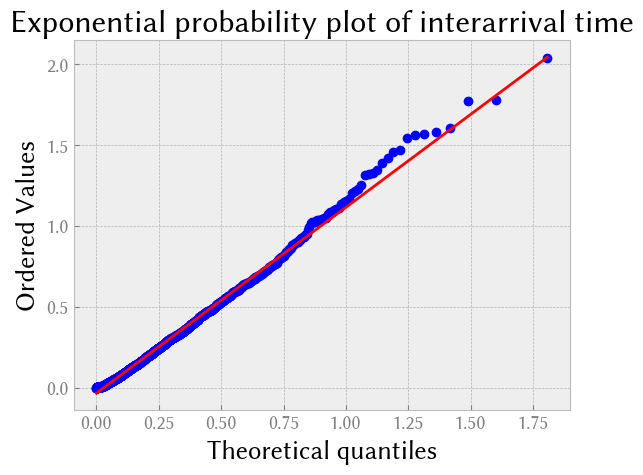

In [9]:
shape, loc = scipy.stats.expon.fit(interarrival)
scipy.stats.probplot(interarrival, 
                     dist="expon", sparams=(shape, loc), 
                     plot=plt.figure().add_subplot(111))
plt.title("Exponential probability plot of interarrival time");

A correlogram or autocorrelation plot tests whether elements of a time series are positively correlated, negatively correlated, or independent of each other. This is important to detect trends or cycles in time series data.

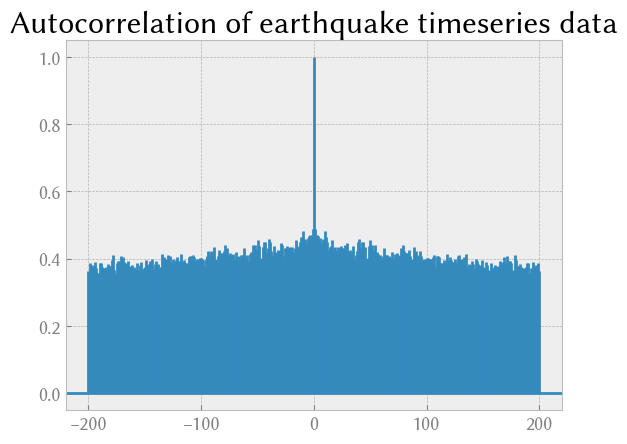

In [10]:
plt.acorr(interarrival, maxlags=200)
plt.title("Autocorrelation of earthquake timeseries data");

There is no visible trend in this time series data (note that we are only examining large earthquakes; the same plot concerning all earthquakes would likely show correlations at small numbers of days, because large earthquakes tend to trigger small aftershocks in the following days, or sometimes large quakes are preceded by small earthquakes).